In [1]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def crop_minAreaRect_with_margin(img, rect, margin=0):
    # Source: https://stackoverflow.com/questions/37177811/

    # Rotate img
    angle = rect[2]
    rows, cols = img.shape[0], img.shape[1]
    matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    img_rot = cv2.warpAffine(img, matrix, (cols, rows))

    # Rotate bounding box
    rect0 = (rect[0], rect[1], 0.0)
    box = cv2.boxPoints(rect)
    pts = np.intp(cv2.transform(np.array([box]), matrix))[0]
    pts[pts < 0] = 0

    # Add margin to the bounding box coordinates
    pts[:, 0] = np.clip(pts[:, 0], margin, cols - 1 - margin)
    pts[:, 1] = np.clip(pts[:, 1], margin, rows - 1 - margin)

    # Crop and return
    return img_rot[
        pts[1][1] - margin : pts[0][1] + margin, pts[1][0] - margin : pts[2][0] + margin
    ]

dtype: uint8, shape: (122, 120, 3), min: 0, max: 255


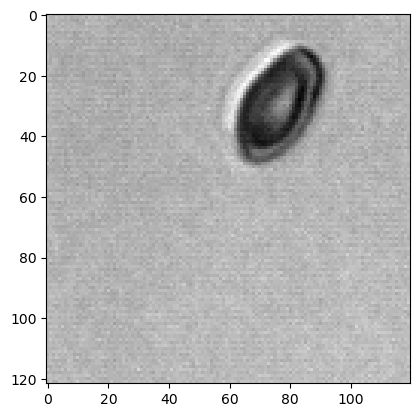

In [3]:
path = (
    "/home/t.afanasyeva/deep_learning_anaemias/resources/images_subset/large_cell.tif"
)
# img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
img = cv2.imread(path)
assert img is not None, "file could not be read, check with os.path.exists()"
8
print(f"dtype: {img.dtype}, shape: {img.shape}, min: {np.min(img)}, max: {np.max(img)}")
plt.imshow(img, cmap="grey")

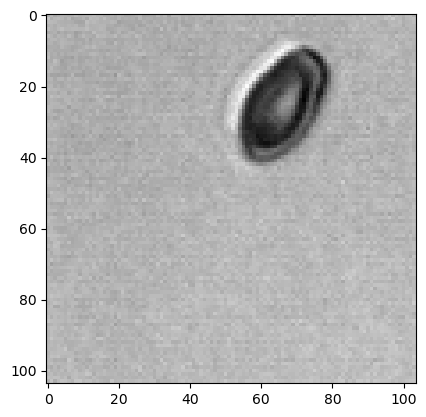

In [4]:
resized = cv2.resize(img, (104, 104), interpolation=cv2.INTER_CUBIC)
plt.imshow(resized, cmap="grey")

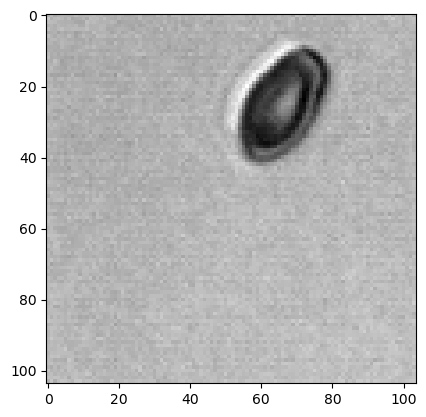

In [5]:
# filt = cv2.pyrMeanShiftFiltering(img, sp=10, sr=30, maxLevel=2)
gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)

plt.imshow(gray, cmap="grey")

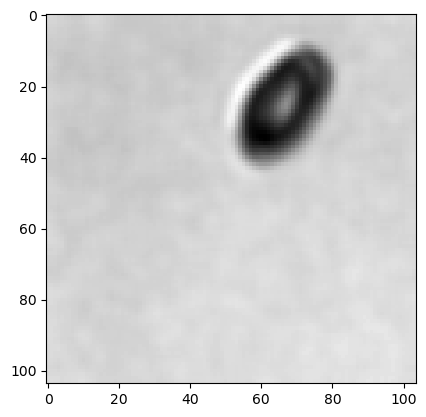

In [6]:
# Smooth image
blur = cv2.GaussianBlur(gray, (5, 5), 3)
plt.imshow(blur, cmap="grey")

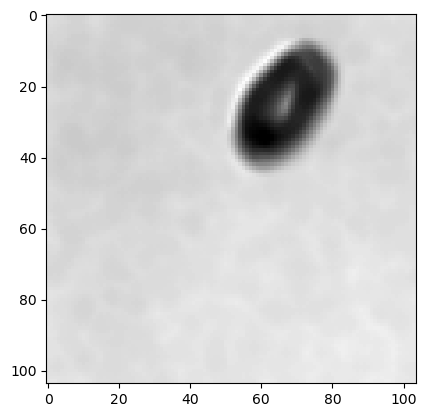

In [7]:
radius = 1  # Define the radius of the circlar kernel
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2 * radius + 1, 2 * radius + 1))

erod = cv2.erode(blur, kernel, iterations=1)

plt.imshow(erod, cmap="grey")

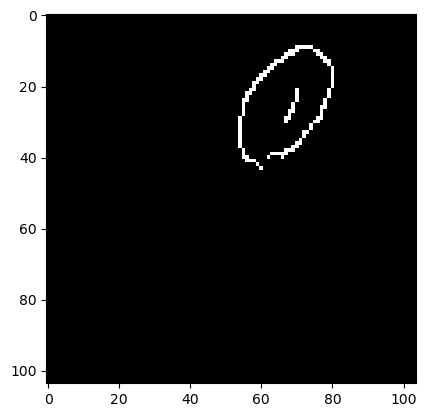

In [8]:
edges = cv2.Canny(blur, threshold1=150, threshold2=200)
plt.imshow(edges, cmap="gray")

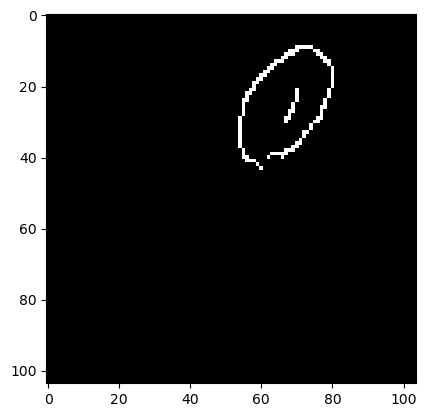

In [9]:
# Remove cells at the border
from skimage.segmentation import clear_border

no_bord = clear_border(edges)
plt.imshow(no_bord, cmap="grey")

In [10]:
contours, hierarchy = cv2.findContours(no_bord, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

valid_contours = []

for i, (contour, h) in enumerate(zip(contours, hierarchy[0])):
    # Check if the contour is not inside another contour (parent index is -1)
    if h[3] == -1:
        area = cv2.contourArea(contour)
        # Check if the area is less than 1200 pixels
        if (area <= 1500) and (area >= 200):
            valid_contours.append(contour)

    if valid_contours:
        # Randomly select one of the valid contours
        cnt = random.choice(valid_contours)

    else:
        print("No valid contours found.")

No valid contours found.
No valid contours found.


In [11]:
mask = np.zeros_like(gray)
cv2.drawContours(mask, [cnt], -1, 255, thickness=cv2.FILLED)
mask_inv = cv2.bitwise_not(mask)

# Set the outside area to white using the inverted mask
gray[mask_inv == 255] = 255


plt.imshow(gray, cmap="grey")

NameError: name 'cnt' is not defined

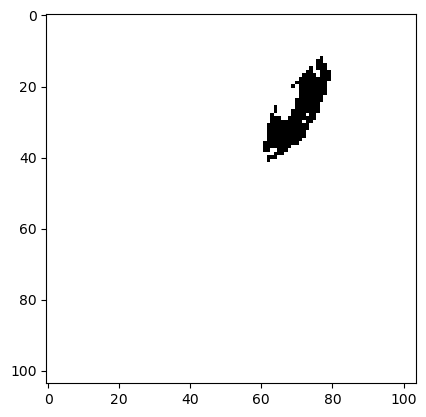

In [ ]:
# threshold
thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)[1]

plt.imshow(thresh, cmap="grey")

In [ ]:
# morphology edgeout = dilated_mask - mask
# morphology dilate
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
dilate = cv2.morphologyEx(thresh, cv2.MORPH_DILATE, kernel)

In [ ]:
# get absolute difference between dilate and thresh
diff = cv2.absdiff(dilate, thresh)

# invert
edges = 255 - diff

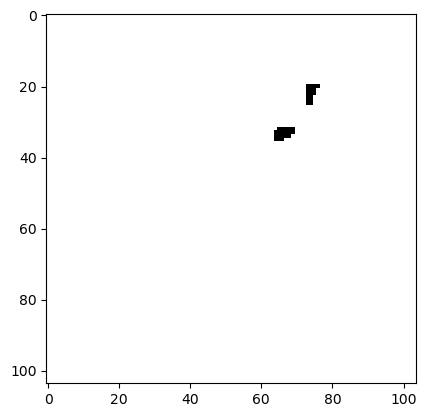

In [ ]:
plt.imshow(dilate, cmap="grey")

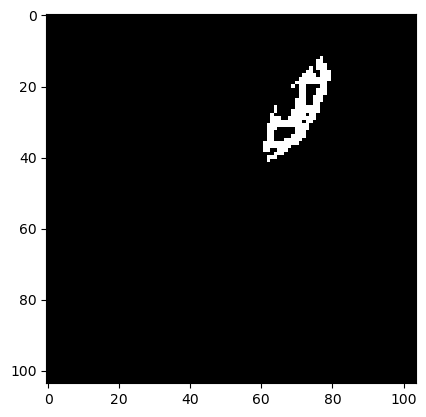

In [ ]:
plt.imshow(diff, cmap="grey")

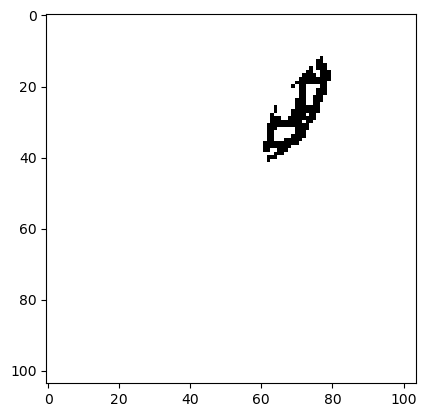

In [ ]:
plt.imshow(edges, cmap="grey")

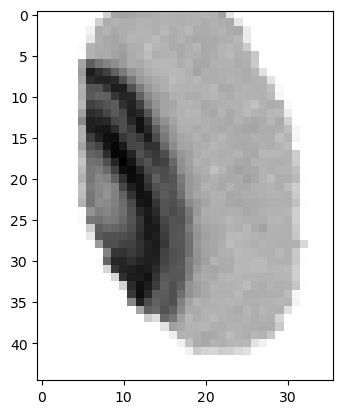

In [ ]:
rect = cv2.minAreaRect(cnt)
croped = crop_minAreaRect_with_margin(gray, rect, margin=5)
plt.imshow(croped, cmap="gray")

In [ ]:
# def image_resize(src, height=None, inter=cv2.INTER_AREA):
#     dimension = None
#     (h, w) = src.shape[:2]

#     if height is None:
#         height = h

#     r = height / float(h)  # Resizing ratio
#     dimension = (int(w * r), height)

#     resized = cv2.resize(src, dimension, interpolation=inter)

#     return resized

In [ ]:
# # Resize the image
# resized = image_resize(croped, height=None)

# plt.imshow(resized, cmap="grey")

(96, 96)


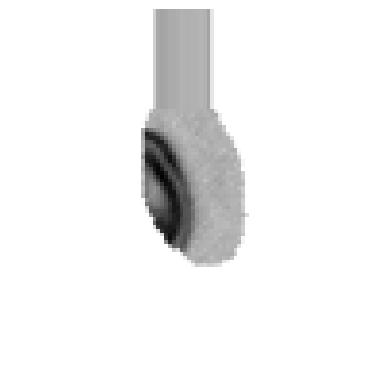

In [ ]:
def image_pad(
    src,
    target_size=(96, 96),
    bordertype=cv2.BORDER_REPLICATE,
):

    # Calculate padding to make the image square
    pad_width = abs(src.shape[1] - src.shape[0])
    left = pad_width // 2
    right = pad_width - left
    top = 0
    bottom = 0

    # Pad the image to make it square
    padded = cv2.copyMakeBorder(src, top, bottom, left, right, bordertype)
    print(target_size)

    # Add additional padding to make the resulting image 100x100
    additional_padding = max(0, target_size[0] - padded.shape[0])
    top_padding = additional_padding // 2
    bottom_padding = additional_padding - top_padding
    additional_padding = max(0, target_size[1] - padded.shape[1])
    left_padding = additional_padding // 2
    right_padding = additional_padding - left_padding

    final_padded = cv2.copyMakeBorder(
        padded, top_padding, bottom_padding, left_padding, right_padding, bordertype
    )

    return final_padded


padded_image = image_pad(croped)
plt.imshow(padded_image, cmap="gray")
plt.axis("off")
plt.show()

In [ ]:
import hashlib


def get_hash_with_randomness(file_path):
    # Generate a random salt
    salt = os.urandom(16)  # 16 bytes of randomness

    # Read the file and compute the hash
    with open(file_path, "rb") as f:
        file_bytes = f.read()  # read entire file as bytes
        bytes_with_salt = file_bytes + salt  # append the salt to the file content
        readable_hash = hashlib.sha256(bytes_with_salt).hexdigest()

    return readable_hash

In [ ]:
hash_for_filename = get_hash_with_randomness(path)
print(hash_for_filename)  # This will be your file name

2947bb001fb5131081b26d221b7efe5c199bbb1961eba101cd6e4aa0ac589eaf


In [ ]:
my_dict = {}
my_dict.setdefault(readable_hash, [])
my_dict[readable_hash].append(path)

NameError: name 'readable_hash' is not defined

In [ ]:
my_dict[readable_hash][0]